In [1]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression

In [2]:
target = "Total"
chart_target = "Total"
file_tag = "Differentiation"

train_path = "../../data/prepared/aggregation/traffic_train_aggregation.csv"
test_path  = "../../data/prepared/aggregation/traffic_test_aggregation.csv"

train_df = read_csv(train_path, parse_dates=["Time"], index_col="Time")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Time"], index_col="Time")
test: Series = test_df[target]
test.index = to_datetime(test.index)

train.head(), test.head()

(Time
 2000-01-01    10185
 2000-01-02     9917
 2000-01-03    10179
 2000-01-04     9836
 2000-01-05    10002
 Name: Total, dtype: int64,
 Time
 2000-02-19     4975
 2000-02-20    10801
 2000-02-21    10960
 2000-02-22    11105
 2000-02-23    11100
 Name: Total, dtype: int64)

**Differentiation**

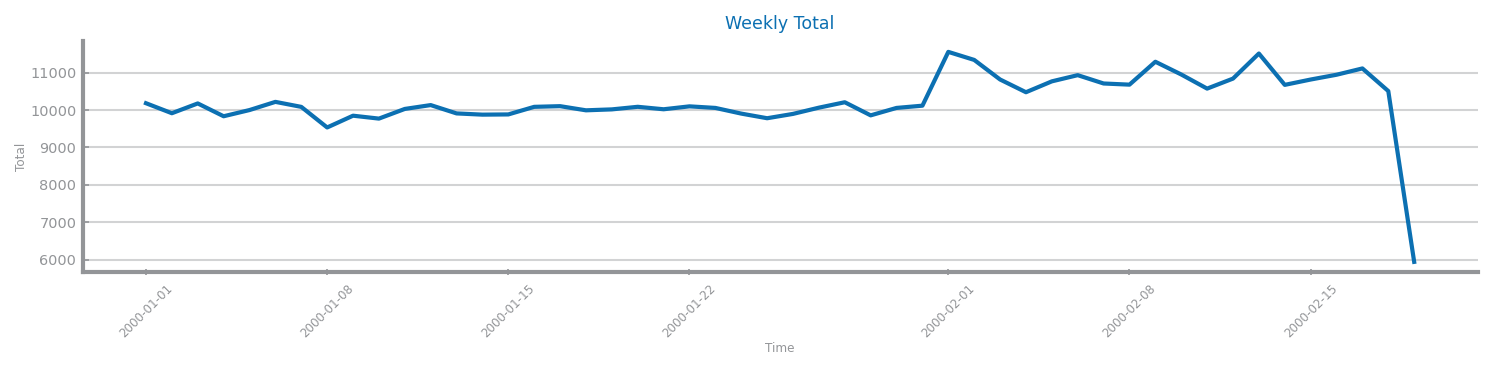

In [3]:
# without any differentiation
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"Weekly {target}",
)
show()

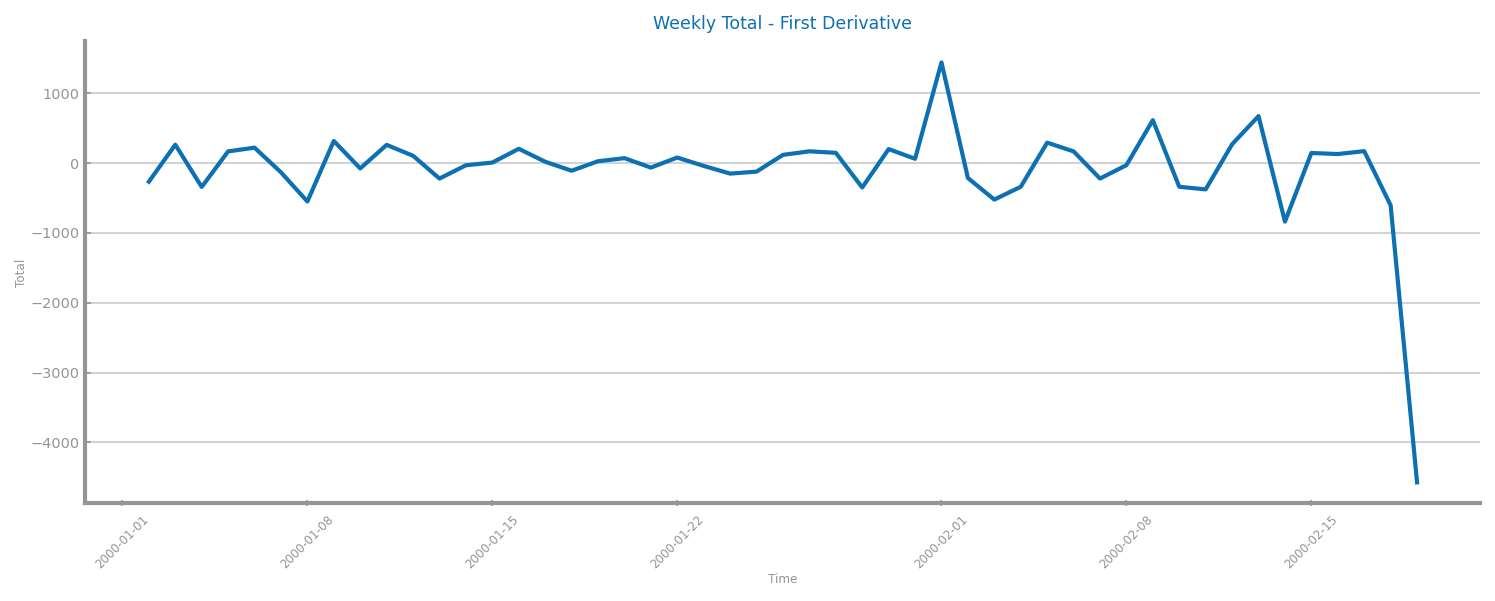

In [4]:
# differential of 1
train_diff1 = train.diff()
test_diff1 = test.diff()
test_diff1.iloc[0] = test.iloc[0] - train.iloc[-1] # bc needs continuity to the end of training set

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff1.index.to_list(),
    train_diff1.to_list(),
    title=f"Weekly {target} - First Derivative",
    xlabel=train_diff1.index.name,
    ylabel=target,
)
show()

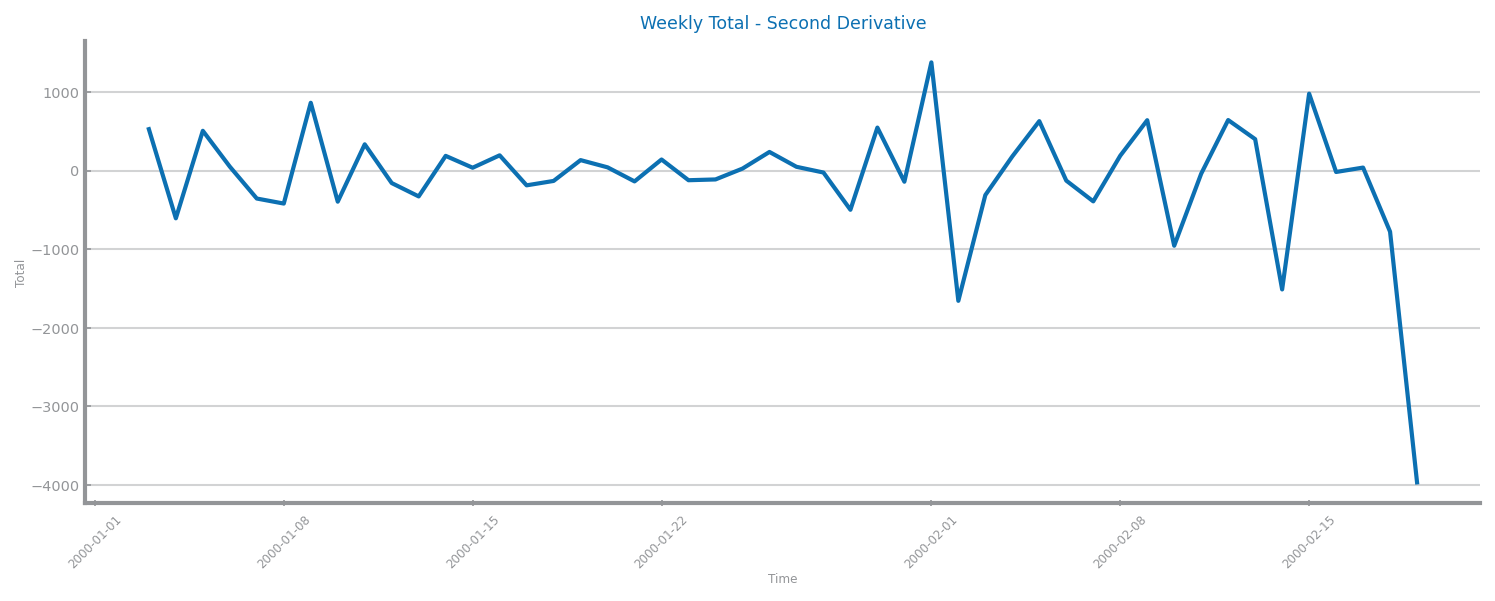

In [5]:
# differential of 2
train_diff2 = train.diff().diff()
test_diff2 = test.diff().diff()

first_diff_train_last = train.diff().iloc[-1]
first_diff_test0 = test.iloc[0] - train.iloc[-1]
test_diff2.iloc[0] = first_diff_test0 - first_diff_train_last

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff2.index.to_list(),
    train_diff2.to_list(),
    title=f"Weekly {target} - Second Derivative",
    xlabel=train_diff2.index.name,
    ylabel=target,
)
show()

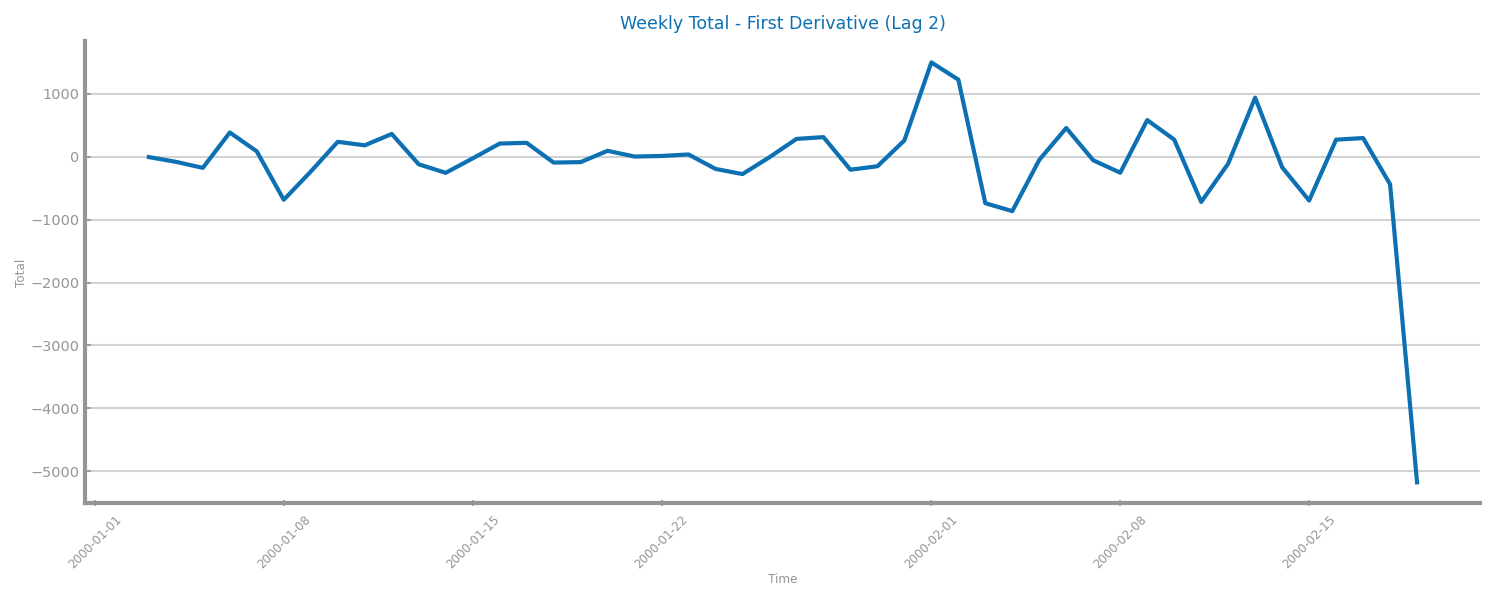

In [6]:
# differential of 1 with lag of 2
train_diff_lag2 = train.diff(2)
test_diff_lag2 = test.diff(2)

test_diff_lag2.iloc[0] = test.iloc[0] - train.iloc[-2]
test_diff_lag2.iloc[1] = test.iloc[1] - train.iloc[-1]

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff_lag2.index.to_list(),
    train_diff_lag2.to_list(),
    title=f"Weekly {target} - First Derivative (Lag 2)",
    xlabel=train_diff_lag2.index.name,
    ylabel=target,
)
show()

**Evaluation**

**Persistent Realist**

In [7]:
# Initialize metrics storage
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

metrics_results = {}

def store_metrics(model_name, diff_type, train_series, test_series, prd_trn, prd_tst):
    """Store metrics for a given model and differentiation type"""
    key = f"{model_name}_{diff_type}"
    metrics_results[key] = {
        "model": model_name,
        "differentiation": diff_type,
        "train_rmse": sqrt(mean_squared_error(train_series, prd_trn)),
        "test_rmse": sqrt(mean_squared_error(test_series, prd_tst)),
        "train_mae": mean_absolute_error(train_series, prd_trn),
        "test_mae": mean_absolute_error(test_series, prd_tst),
        "train_mape": mean_absolute_percentage_error(train_series, prd_trn),
        "test_mape": mean_absolute_percentage_error(test_series, prd_tst),
        "train_r2": r2_score(train_series, prd_trn),
        "test_r2": r2_score(test_series, prd_tst),
    }
    return metrics_results[key]


**Baseline (No Differentiation)**

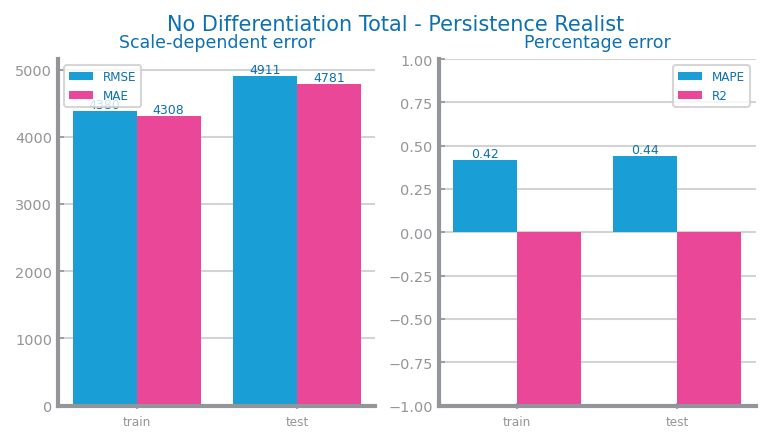

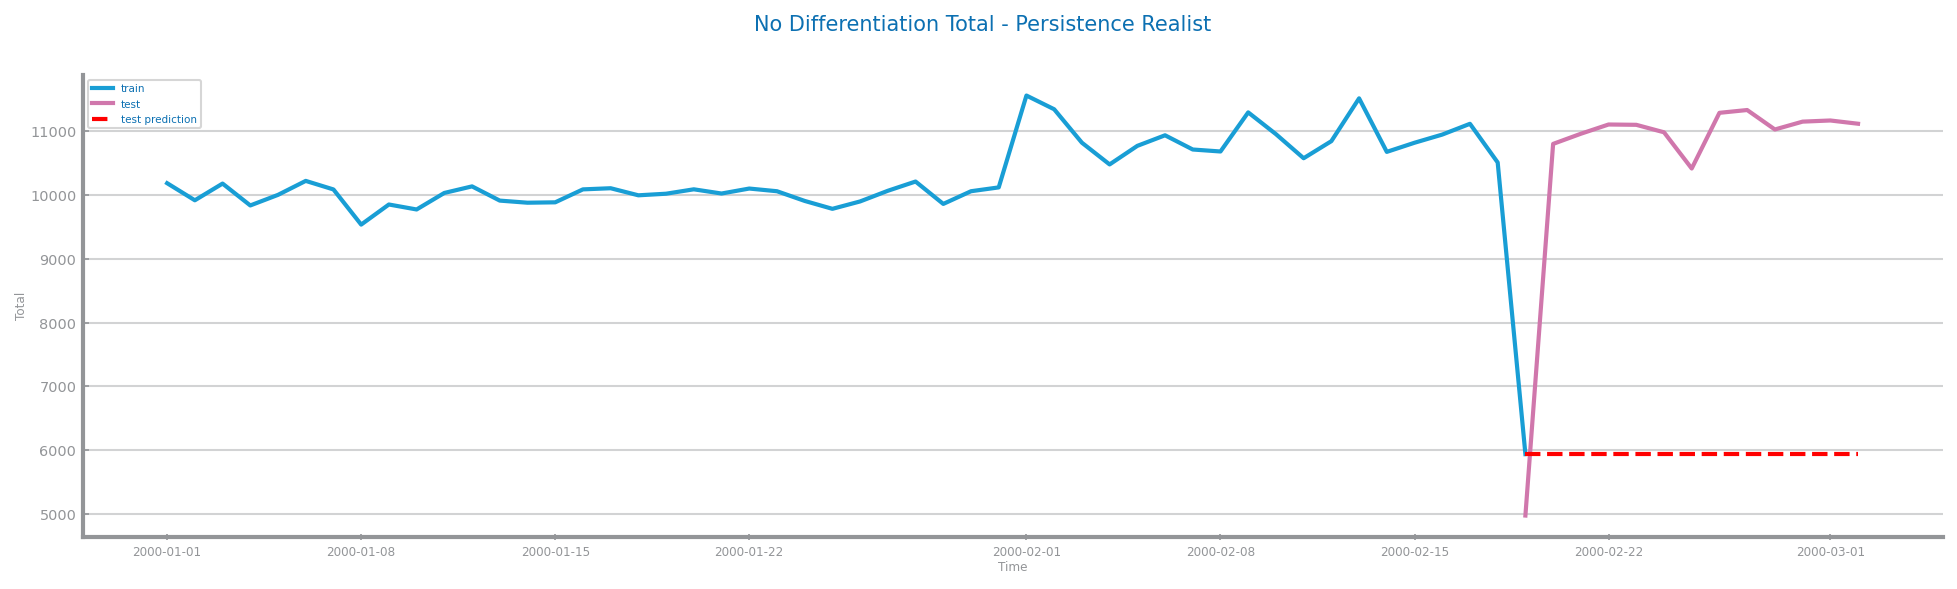

In [8]:
timecol = "Time"

# Baseline - No differentiation with Persistence Realist
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn_baseline: Series = fr_mod.predict(train)
prd_tst_baseline: Series = fr_mod.predict(test)

store_metrics("Persistence_Realist", "None", train, test, prd_trn_baseline, prd_tst_baseline)

plot_forecasting_eval(train, test, prd_trn_baseline, prd_tst_baseline, title=f"No Differentiation {target} - Persistence Realist")
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_baseline_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst_baseline,
    title=f"No Differentiation {target} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_baseline_forecast.png")


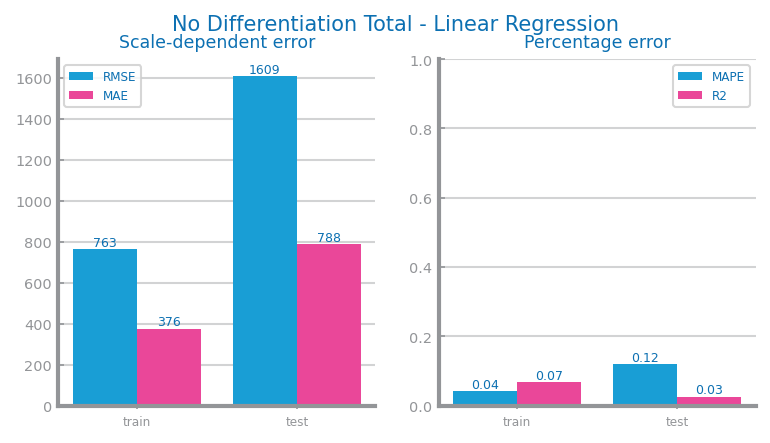

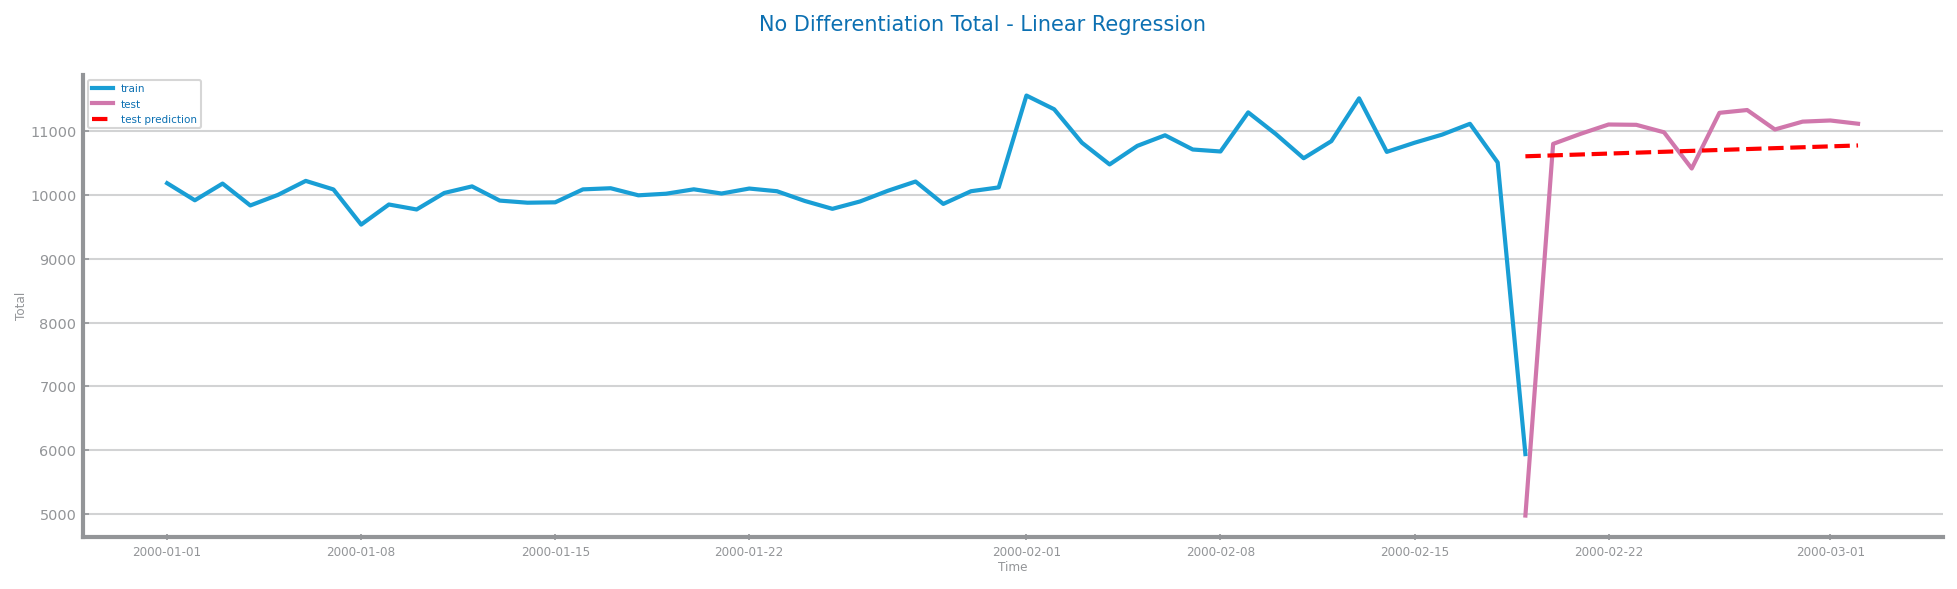

In [9]:
# Baseline - No differentiation with Linear Regression
n_trn = len(train)
n_tst = len(test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_baseline: Series = Series(model.predict(trnX), index=train.index)
prd_tst_baseline: Series = Series(model.predict(tstX), index=test.index)

store_metrics("Linear_Regression", "None", train, test, prd_trn_baseline, prd_tst_baseline)

plot_forecasting_eval(
    train,
    test,
    prd_trn_baseline,
    prd_tst_baseline,
    title=f"No Differentiation {target} - Linear Regression"
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_baseline_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst_baseline,
    title=f"No Differentiation {target} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_baseline_forecast.png")


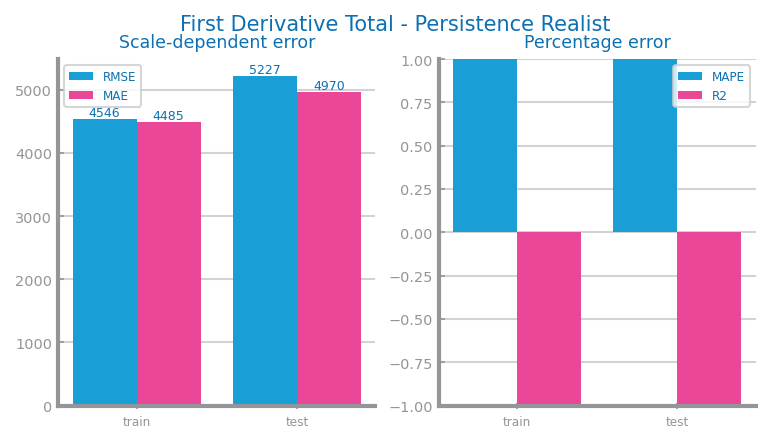

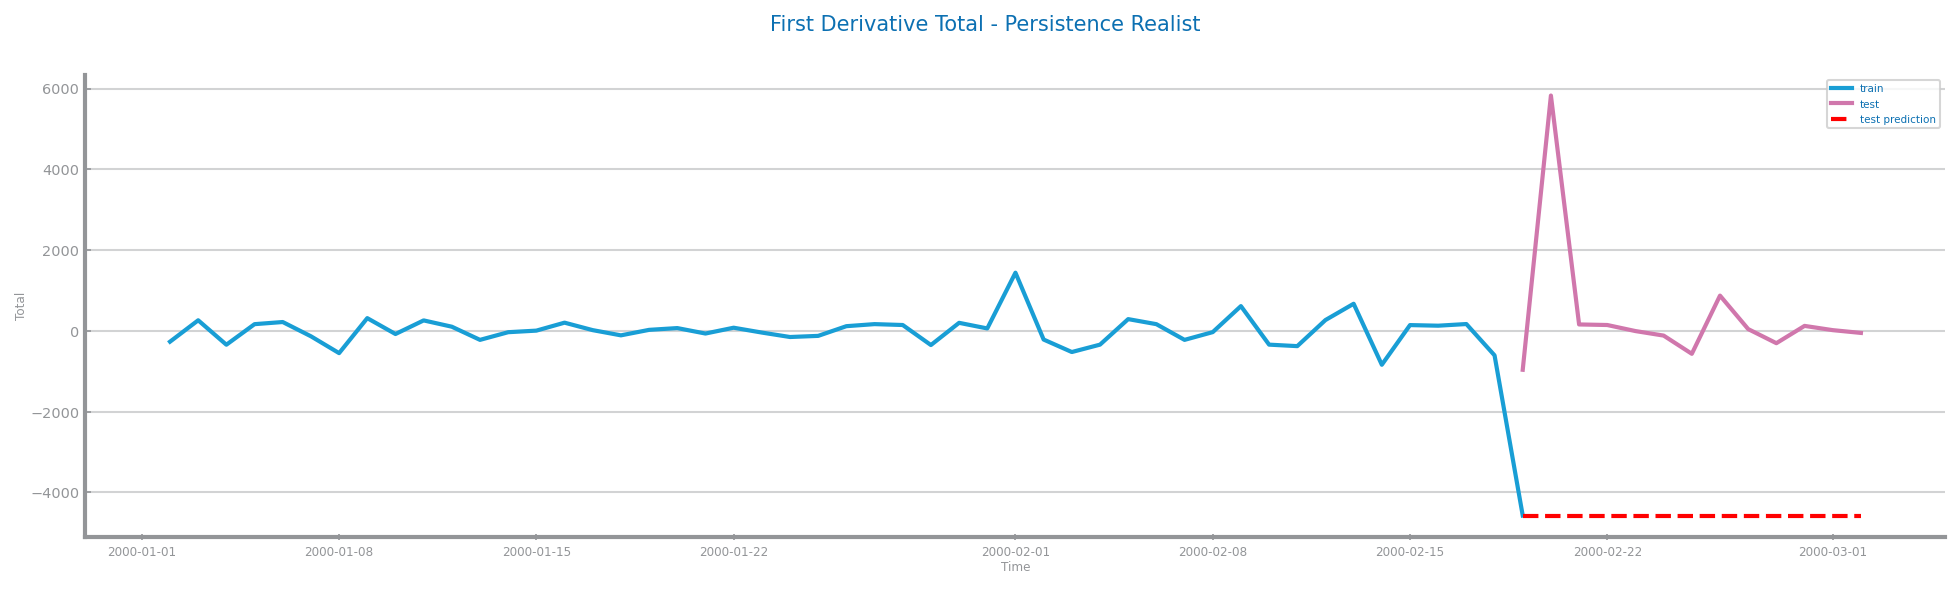

In [10]:
train_diff1 = train_diff1.dropna()
timecol="Time"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff1)
prd_trn_diff1: Series = fr_mod.predict(train_diff1)
prd_tst_diff1: Series = fr_mod.predict(test_diff1)

store_metrics("Persistence_Realist", "Diff1", train_diff1, test_diff1, prd_trn_diff1, prd_tst_diff1)

plot_forecasting_eval(train_diff1, test_diff1, prd_trn_diff1, prd_tst_diff1, title=f"First Derivative {target} - Persistence Realist")
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff1_eval.png")

plot_forecasting_series(
    train_diff1,
    test_diff1,
    prd_tst_diff1,
    title=f"First Derivative {target} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff1_forecast.png")


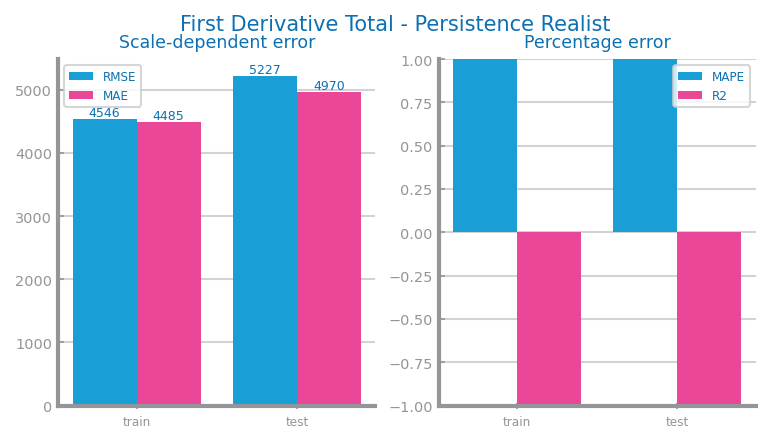

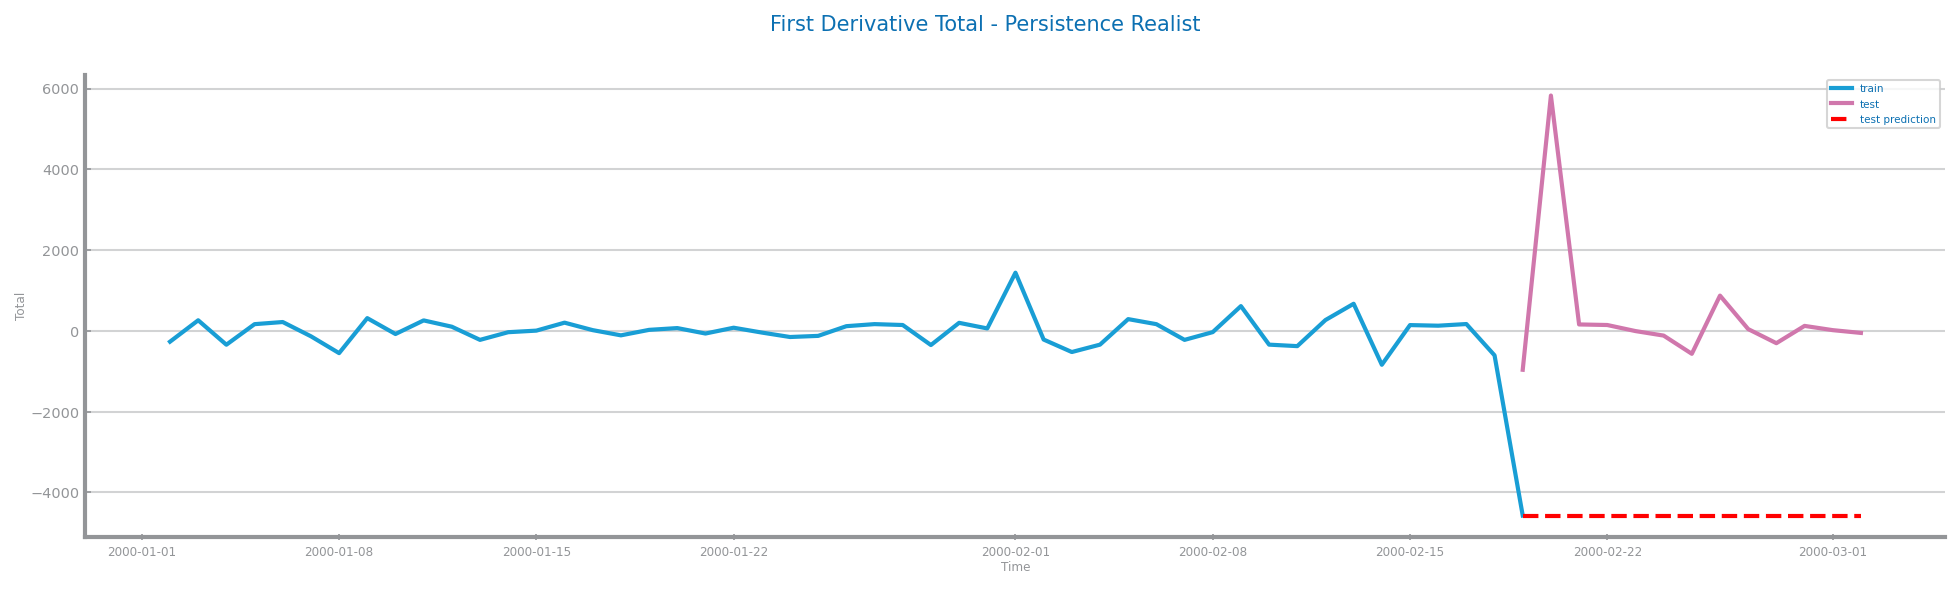

In [11]:
train_diff1_clean = train_diff1.dropna()
test_diff1_clean = test_diff1.dropna()
timecol="Time"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff1_clean)
prd_trn_diff1: Series = fr_mod.predict(train_diff1_clean)
prd_tst_diff1: Series = fr_mod.predict(test_diff1_clean)

store_metrics("Persistence_Realist", "Diff1", train_diff1_clean, test_diff1_clean, prd_trn_diff1, prd_tst_diff1)

plot_forecasting_eval(train_diff1_clean, test_diff1_clean, prd_trn_diff1, prd_tst_diff1, title=f"First Derivative {target} - Persistence Realist")
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff1_eval.png")

plot_forecasting_series(
    train_diff1_clean,
    test_diff1_clean,
    prd_tst_diff1,
    title=f"First Derivative {target} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff1_forecast.png")


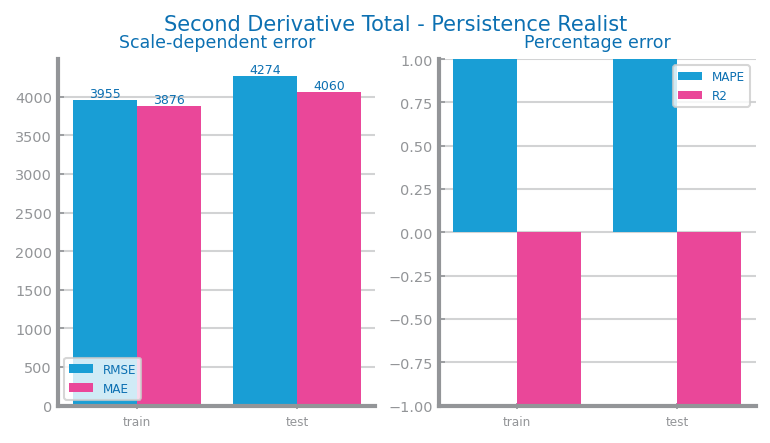

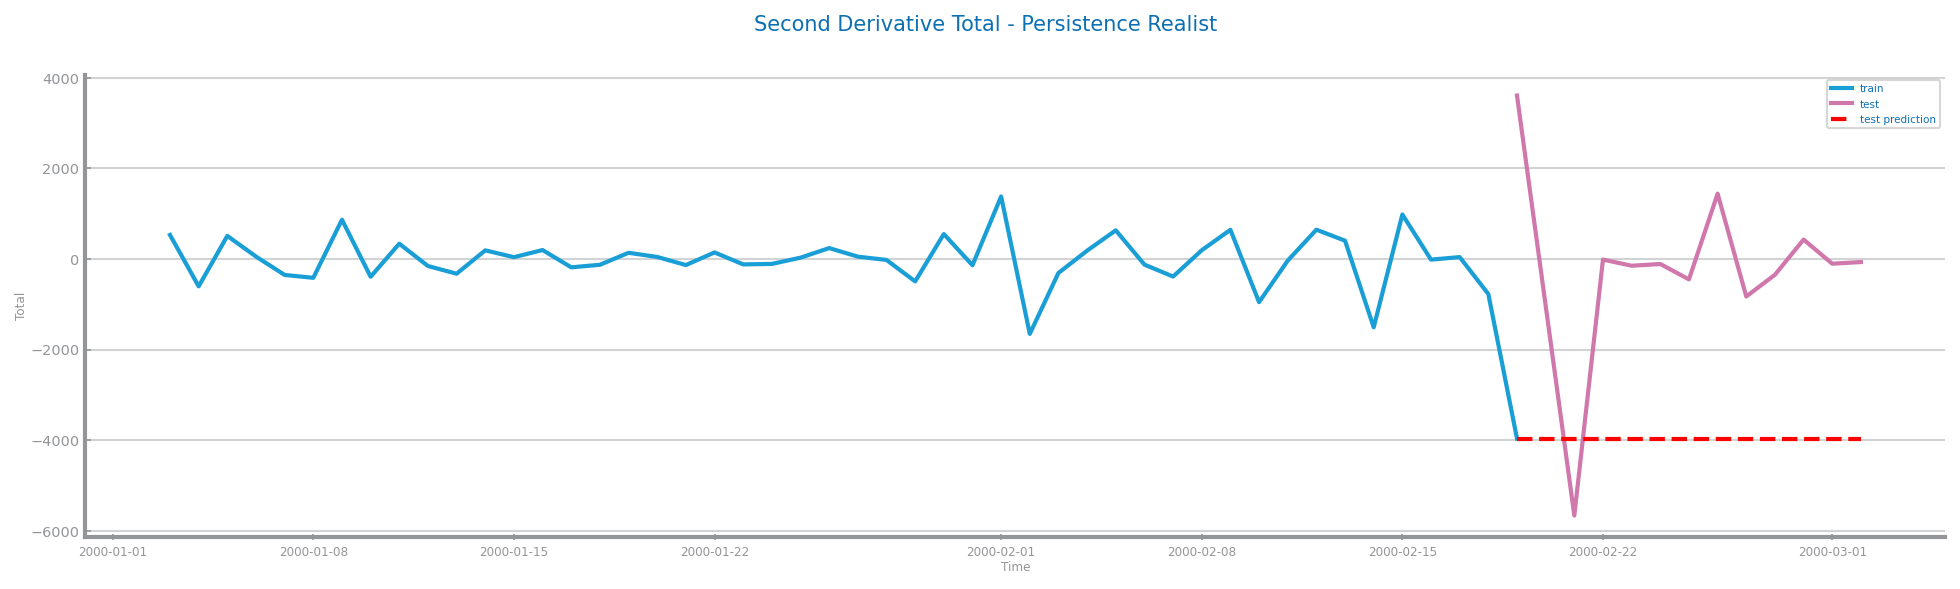

In [12]:
train_diff2_clean = train_diff2.dropna()
test_diff2_clean = test_diff2.dropna()
timecol="Time"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff2_clean)
prd_trn_diff2: Series = fr_mod.predict(train_diff2_clean)
prd_tst_diff2: Series = fr_mod.predict(test_diff2_clean)

store_metrics("Persistence_Realist", "Diff2", train_diff2_clean, test_diff2_clean, prd_trn_diff2, prd_tst_diff2)

plot_forecasting_eval(train_diff2_clean, test_diff2_clean, prd_trn_diff2, prd_tst_diff2, title=f"Second Derivative {target} - Persistence Realist")
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff2_eval.png")

plot_forecasting_series(
    train_diff2_clean,
    test_diff2_clean,
    prd_tst_diff2,
    title=f"Second Derivative {target} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff2_forecast.png")


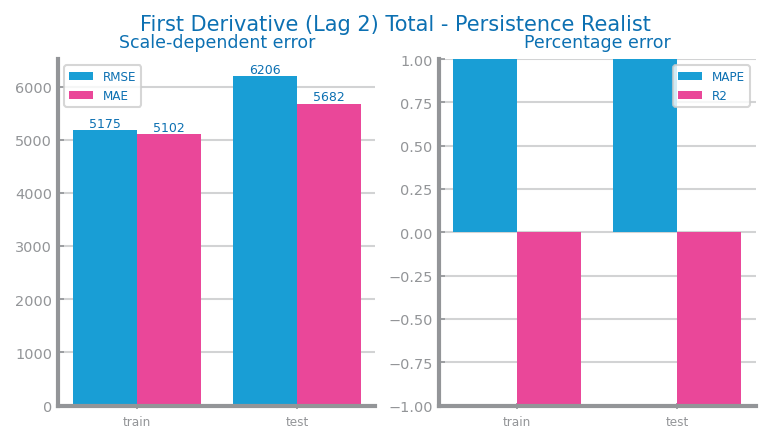

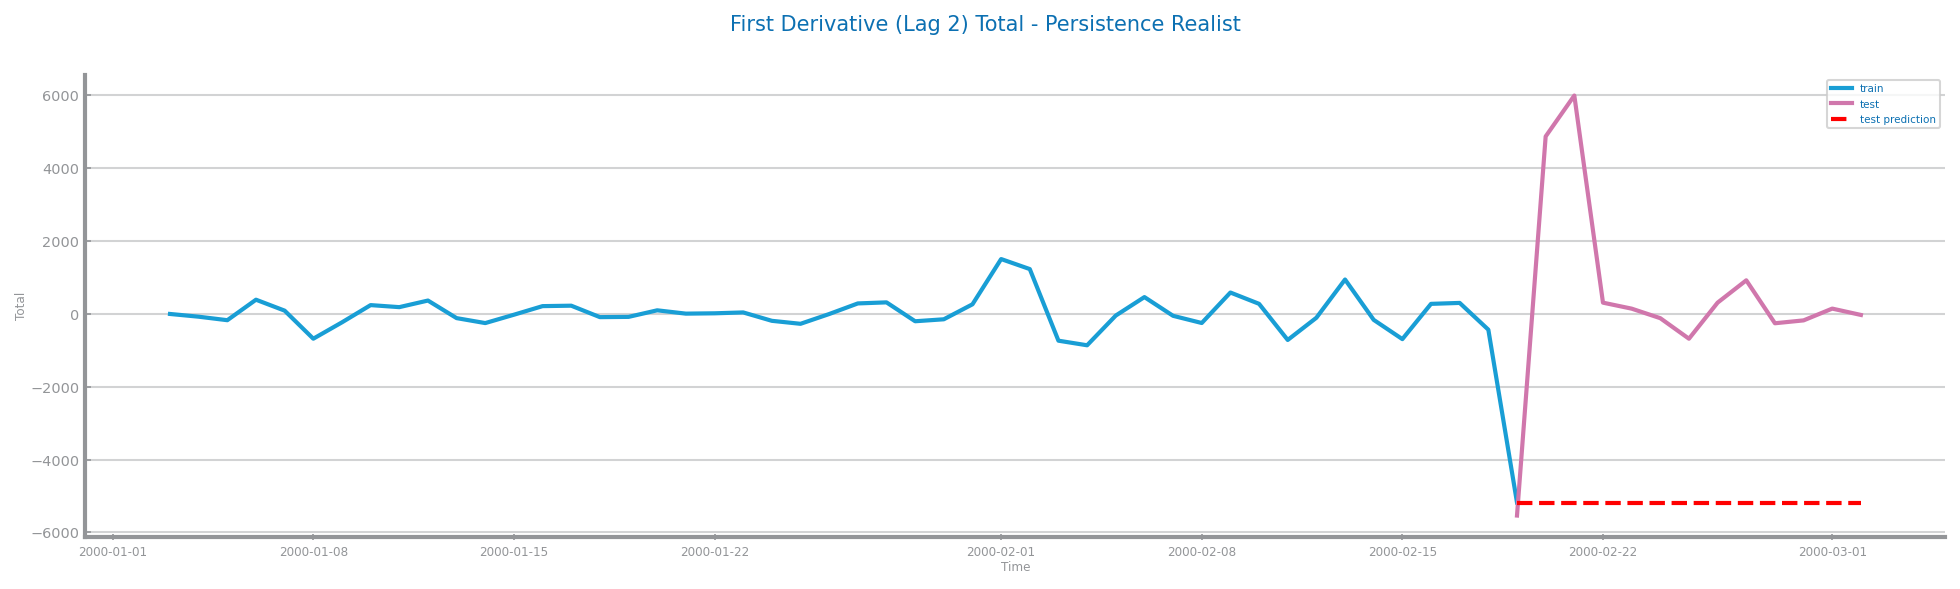

In [13]:
train_diff_lag2_clean = train_diff_lag2.dropna()
test_diff_lag2_clean = test_diff_lag2.dropna()
timecol="Time"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff_lag2_clean)
prd_trn_diff_lag2: Series = fr_mod.predict(train_diff_lag2_clean)
prd_tst_diff_lag2: Series = fr_mod.predict(test_diff_lag2_clean)

store_metrics("Persistence_Realist", "Diff1_Lag2", train_diff_lag2_clean, test_diff_lag2_clean, prd_trn_diff_lag2, prd_tst_diff_lag2)

plot_forecasting_eval(train_diff_lag2_clean, test_diff_lag2_clean, prd_trn_diff_lag2, prd_tst_diff_lag2, title=f"First Derivative (Lag 2) {target} - Persistence Realist")
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff_lag2_eval.png")

plot_forecasting_series(
    train_diff_lag2_clean,
    test_diff_lag2_clean,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) {target} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_persistence_real_diff_lag2_forecast.png")


**Linear Regression**

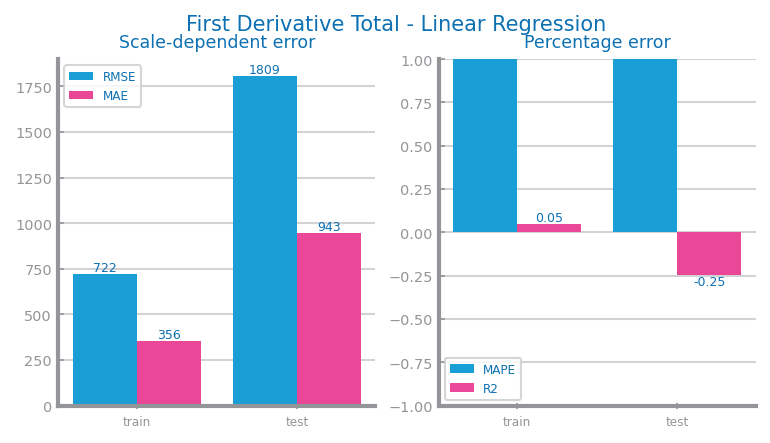

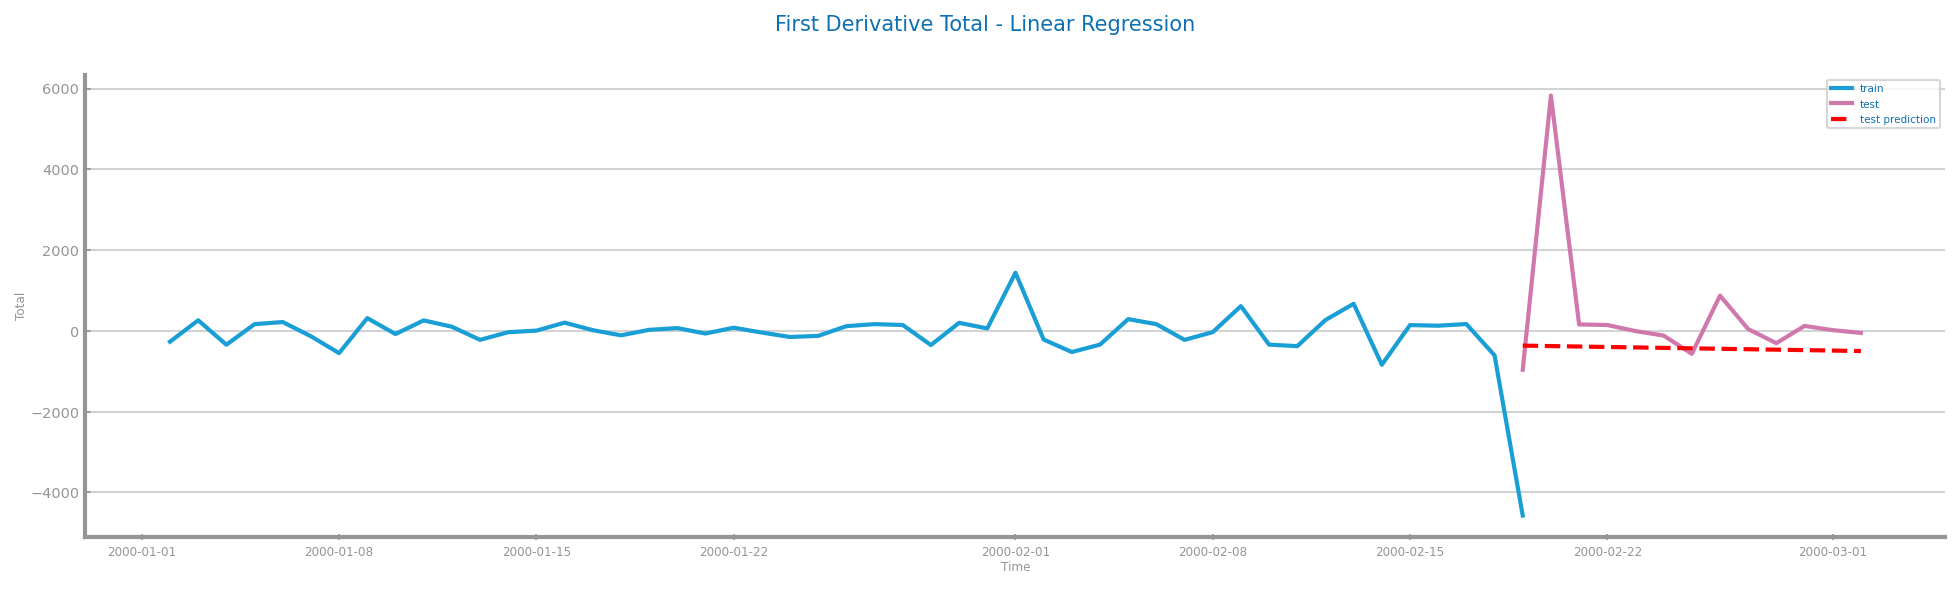

In [14]:
train_diff1_clean = train_diff1.dropna()
test_diff1_clean = test_diff1.dropna()

n_trn = len(train_diff1_clean)
n_tst = len(test_diff1_clean)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff1_clean.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff1_clean.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff1: Series = Series(model.predict(trnX), index=train_diff1_clean.index)
prd_tst_diff1: Series = Series(model.predict(tstX), index=test_diff1_clean.index)

store_metrics("Linear_Regression", "Diff1", train_diff1_clean, test_diff1_clean, prd_trn_diff1, prd_tst_diff1)

plot_forecasting_eval(
    train_diff1_clean,
    test_diff1_clean,
    prd_trn_diff1,
    prd_tst_diff1,
    title=f"First Derivative {target} - Linear Regression"
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff1_eval.png")

plot_forecasting_series(
    train_diff1_clean,
    test_diff1_clean,
    prd_tst_diff1,
    title=f"First Derivative {target} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff1_forecast.png")


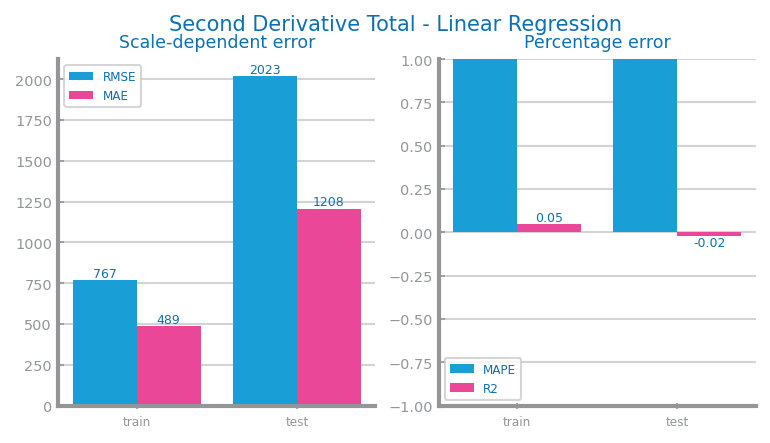

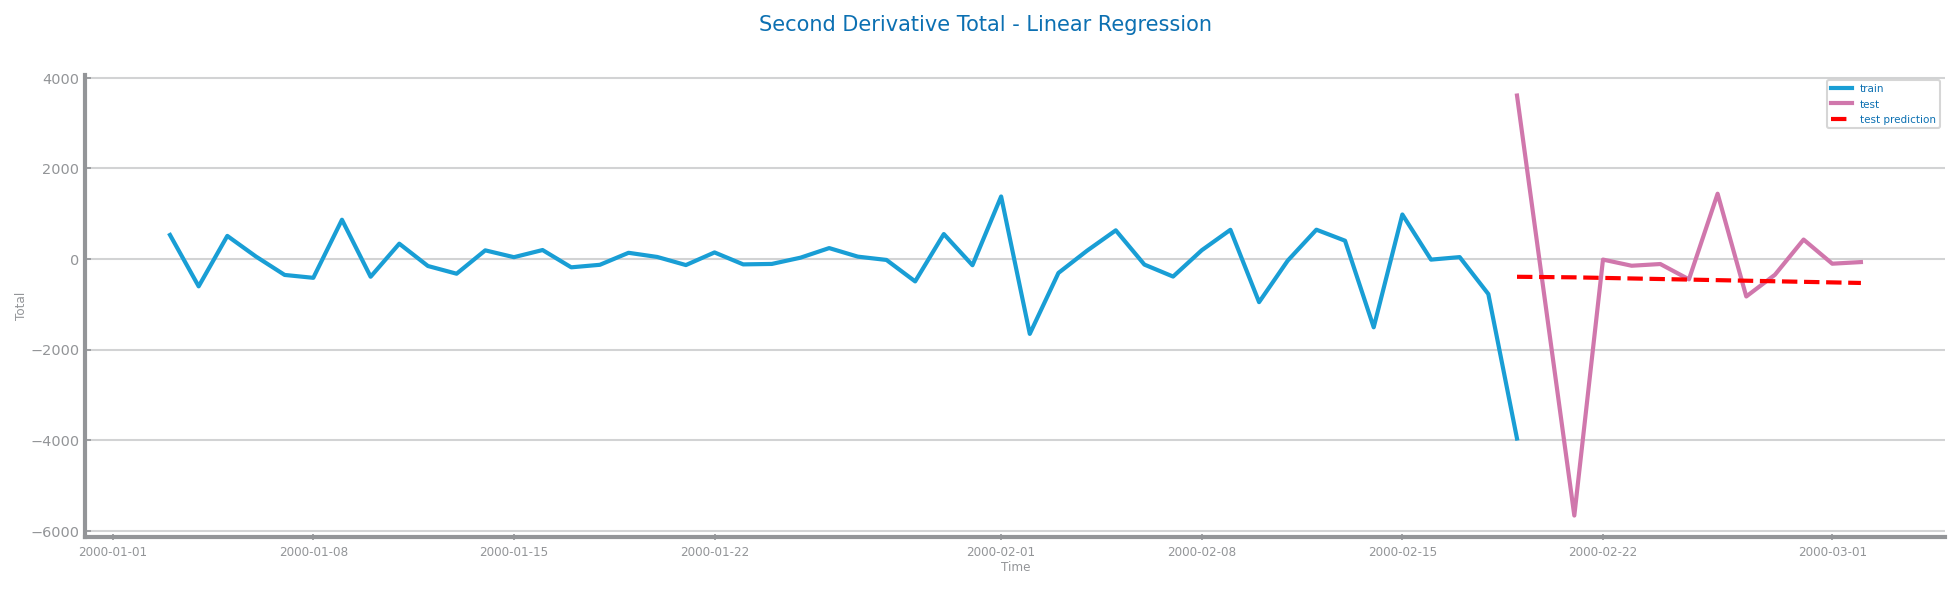

In [15]:
train_diff2_clean = train_diff2.dropna()
test_diff2_clean = test_diff2.dropna()

n_trn = len(train_diff2_clean)
n_tst = len(test_diff2_clean)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff2_clean.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff2_clean.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff2: Series = Series(model.predict(trnX), index=train_diff2_clean.index)
prd_tst_diff2: Series = Series(model.predict(tstX), index=test_diff2_clean.index)

store_metrics("Linear_Regression", "Diff2", train_diff2_clean, test_diff2_clean, prd_trn_diff2, prd_tst_diff2)

plot_forecasting_eval(
    train_diff2_clean,
    test_diff2_clean,
    prd_trn_diff2,
    prd_tst_diff2,
    title=f"Second Derivative {target} - Linear Regression"
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff2_eval.png")

plot_forecasting_series(
    train_diff2_clean,
    test_diff2_clean,
    prd_tst_diff2,
    title=f"Second Derivative {target} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff2_forecast.png")


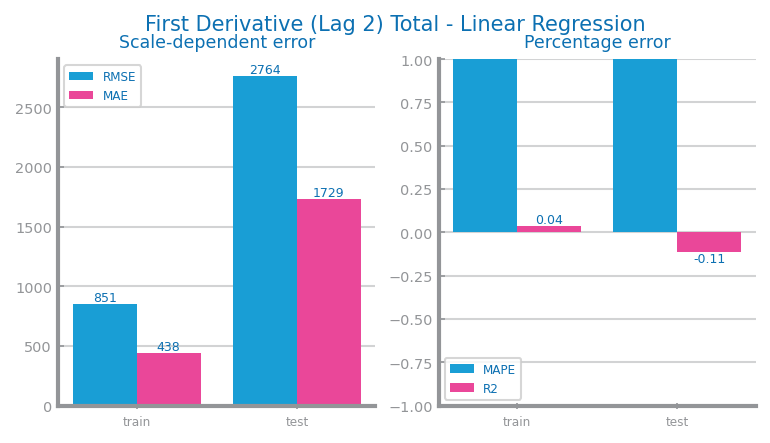

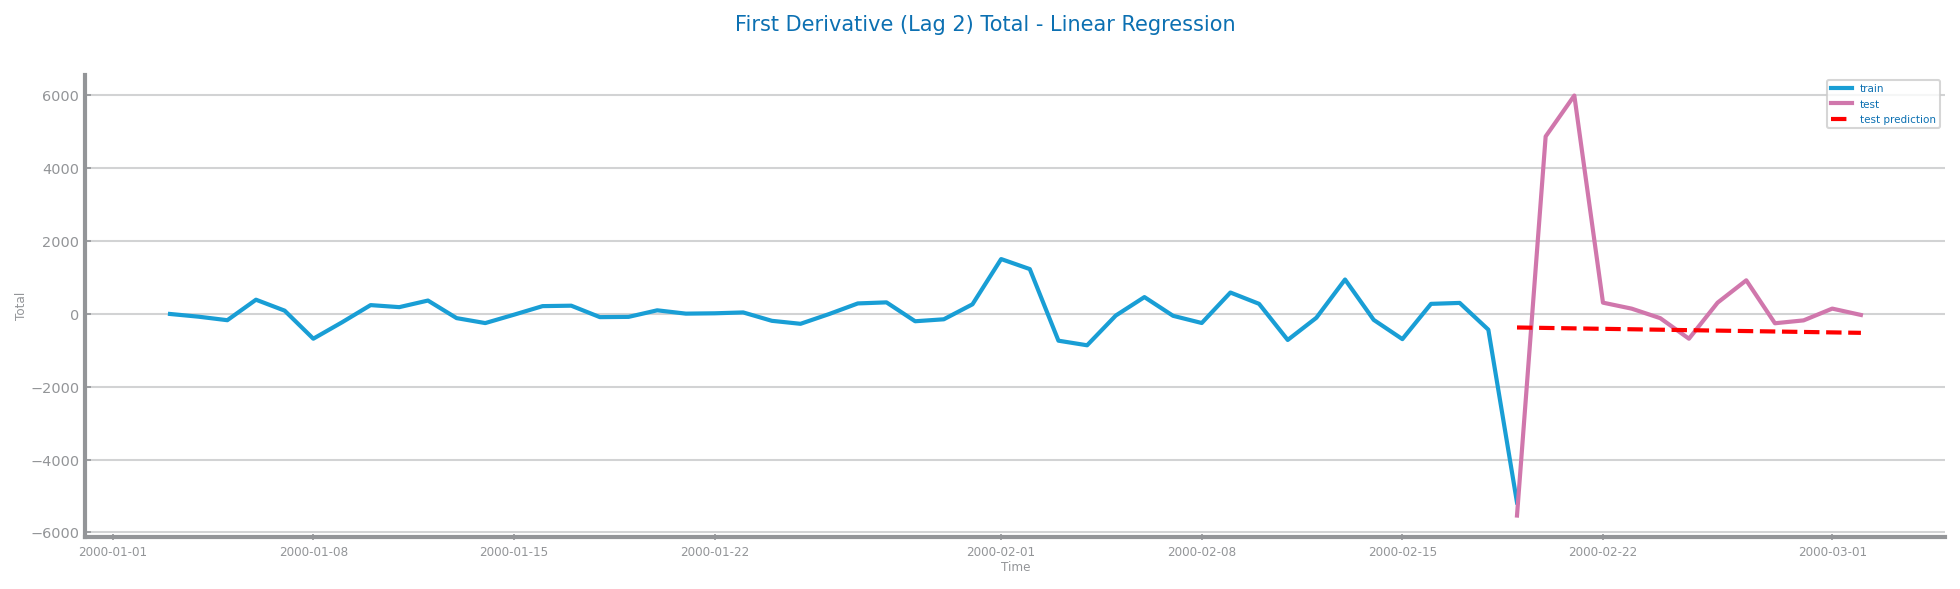

In [16]:
train_diff_lag2_clean = train_diff_lag2.dropna()
test_diff_lag2_clean = test_diff_lag2.dropna()

n_trn = len(train_diff_lag2_clean)
n_tst = len(test_diff_lag2_clean)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff_lag2_clean.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff_lag2_clean.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff_lag2: Series = Series(model.predict(trnX), index=train_diff_lag2_clean.index)
prd_tst_diff_lag2: Series = Series(model.predict(tstX), index=test_diff_lag2_clean.index)

store_metrics("Linear_Regression", "Diff1_Lag2", train_diff_lag2_clean, test_diff_lag2_clean, prd_trn_diff_lag2, prd_tst_diff_lag2)

plot_forecasting_eval(
    train_diff_lag2_clean,
    test_diff_lag2_clean,
    prd_trn_diff_lag2,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) {target} - Linear Regression"
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff_lag2_eval.png")

plot_forecasting_series(
    train_diff_lag2_clean,
    test_diff_lag2_clean,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) {target} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/preparation/differential/{file_tag}_linear_regression_diff_lag2_forecast.png")


In [17]:
# Convert metrics to DataFrame for easy comparison
metrics_df = DataFrame.from_dict(metrics_results, orient='index')
metrics_df = metrics_df.reset_index(drop=True)

# Display all metrics
print("="*80)
print("ALL MODEL METRICS (Test Set)")
print("="*80)
display_df = metrics_df[['model', 'differentiation', 'test_rmse', 'test_mae', 'test_mape', 'test_r2']].copy()
display_df = display_df.sort_values(['model', 'differentiation'])
print(display_df.to_string(index=False))
print()

# Find best models by different criteria
print("="*80)
print("BEST MODELS BY CRITERIA (Test Set)")
print("="*80)

# Best by MAPE (scale-independent)
best_mape = metrics_df.loc[metrics_df['test_mape'].idxmin()]
print(f"Best MAPE: {best_mape['model']} ({best_mape['differentiation']}) = {best_mape['test_mape']:.4f}")

# Best by R2 (scale-independent)
best_r2 = metrics_df.loc[metrics_df['test_r2'].idxmax()]
print(f"Best R²: {best_r2['model']} ({best_r2['differentiation']}) = {best_r2['test_r2']:.4f}")

# Best by MAE for each differentiation type
print(f"\nBest MAE by Differentiation Type:")
for diff in ['None', 'Diff1', 'Diff2', 'Diff1_Lag2']:
    diff_df = metrics_df[metrics_df['differentiation'] == diff]
    if len(diff_df) > 0:
        best_mae_diff = diff_df.loc[diff_df['test_mae'].idxmin()]
        print(f"  {diff}: {best_mae_diff['model']} = {best_mae_diff['test_mae']:.2f}")

# Compare baseline (None) vs best differentiated
baseline_df = metrics_df[metrics_df['differentiation'] == 'None']
diff_df = metrics_df[metrics_df['differentiation'] != 'None']
if len(diff_df) > 0:
    best_baseline = baseline_df.loc[baseline_df['test_mape'].idxmin()]
    best_diff = diff_df.loc[diff_df['test_mape'].idxmin()]
    
    print(f"\n{'='*80}")
    print("DIFFERENTIATION IMPACT")
    print("="*80)
    print(f"Best Baseline (No Diff): {best_baseline['model']} - MAPE: {best_baseline['test_mape']:.4f}")
    print(f"Best Differentiated: {best_diff['model']} ({best_diff['differentiation']}) - MAPE: {best_diff['test_mape']:.4f}")
    
    improvement = ((best_baseline['test_mape'] - best_diff['test_mape']) / best_baseline['test_mape']) * 100
    if best_diff['test_mape'] < best_baseline['test_mape']:
        print(f"Improvement: {improvement:.2f}% (differentiation helps!)")
    else:
        print(f"Degradation: {-improvement:.2f}% (differentiation hurts)")

print()
print("="*80)
print("RECOMMENDATION")
print("="*80)
print(f"Overall Best Model: {best_mape['model']} with {best_mape['differentiation']} differentiation")
print(f"  - Test MAPE: {best_mape['test_mape']:.4f}")
print(f"  - Test R²: {best_mape['test_r2']:.4f}")
print(f"  - Test RMSE: {best_mape['test_rmse']:.2f}")
print(f"  - Test MAE: {best_mape['test_mae']:.2f}")

# Store best model info for later use
best_model_name = best_mape['model']
best_differentiation = best_mape['differentiation']


ALL MODEL METRICS (Test Set)
              model differentiation   test_rmse    test_mae  test_mape   test_r2
  Linear_Regression           Diff1 1808.544475  943.431735  11.371381 -0.248256
  Linear_Regression      Diff1_Lag2 2763.922691 1729.005248   2.966446 -0.114137
  Linear_Regression           Diff2 2022.635504 1207.876327   4.227793 -0.022034
  Linear_Regression            None 1609.220598  788.157518   0.119092  0.026172
Persistence_Realist           Diff1 5227.336437 4970.384615 117.946042 -9.428121
Persistence_Realist      Diff1_Lag2 6206.431757 5681.923077  28.658511 -4.617861
Persistence_Realist           Diff2 4274.176334 4060.500000  39.478798 -3.563889
Persistence_Realist            None 4911.461094 4781.000000   0.441124 -8.071364

BEST MODELS BY CRITERIA (Test Set)
Best MAPE: Linear_Regression (None) = 0.1191
Best R²: Linear_Regression (None) = 0.0262

Best MAE by Differentiation Type:
  None: Linear_Regression = 788.16
  Diff1: Linear_Regression = 943.43
  Diff2: Lin

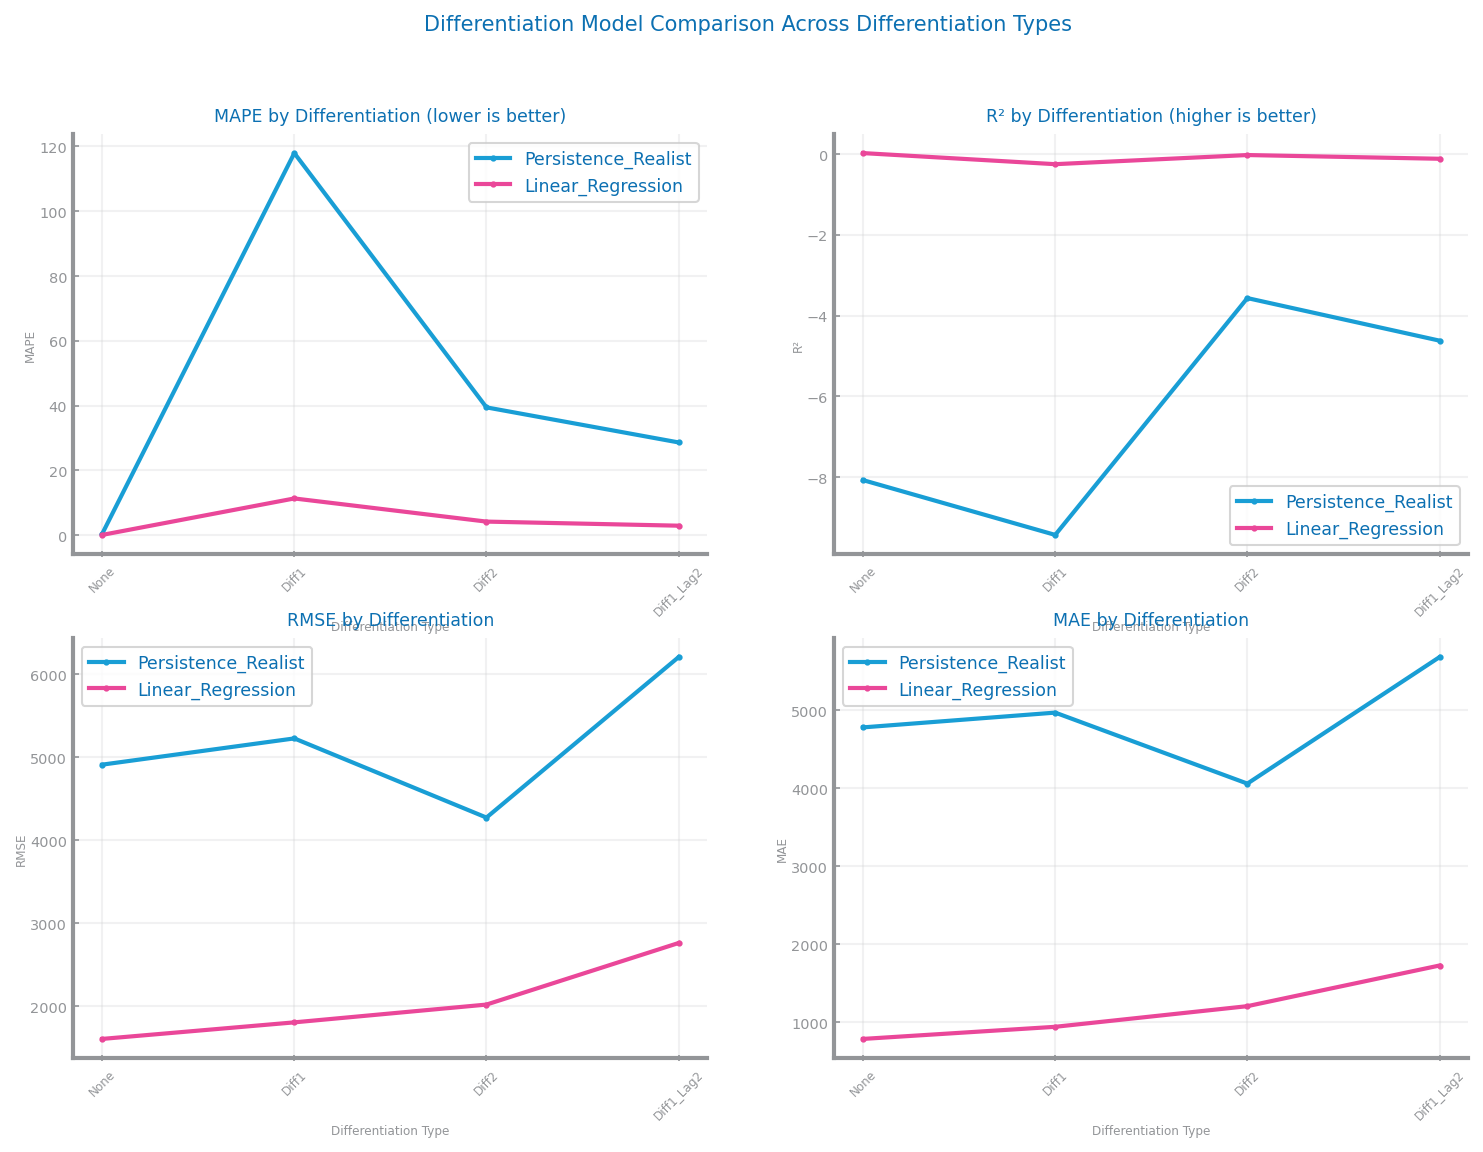

In [18]:
# Visualize model comparison
fig, axs = subplots(2, 2, figsize=(3 * HEIGHT, 2 * HEIGHT))
fig.suptitle(f"{file_tag} Model Comparison Across Differentiation Types")

# Prepare data for plotting
models = metrics_df['model'].unique()
differentiations = ['None', 'Diff1', 'Diff2', 'Diff1_Lag2']

# Plot 1: MAPE comparison (lower is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('differentiation', 
                                                                       key=lambda x: x.map({d: i for i, d in enumerate(differentiations)}))
    axs[0, 0].plot(model_data['differentiation'], model_data['test_mape'], marker='o', label=model)
axs[0, 0].set_title('MAPE by Differentiation (lower is better)')
axs[0, 0].set_xlabel('Differentiation Type')
axs[0, 0].set_ylabel('MAPE')
axs[0, 0].legend(fontsize='small')
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: R² comparison (higher is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('differentiation', 
                                                                       key=lambda x: x.map({d: i for i, d in enumerate(differentiations)}))
    axs[0, 1].plot(model_data['differentiation'], model_data['test_r2'], marker='o', label=model)
axs[0, 1].set_title('R² by Differentiation (higher is better)')
axs[0, 1].set_xlabel('Differentiation Type')
axs[0, 1].set_ylabel('R²')
axs[0, 1].legend(fontsize='small')
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: RMSE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('differentiation', 
                                                                       key=lambda x: x.map({d: i for i, d in enumerate(differentiations)}))
    axs[1, 0].plot(model_data['differentiation'], model_data['test_rmse'], marker='o', label=model)
axs[1, 0].set_title('RMSE by Differentiation')
axs[1, 0].set_xlabel('Differentiation Type')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].legend(fontsize='small')
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: MAE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('differentiation', 
                                                                       key=lambda x: x.map({d: i for i, d in enumerate(differentiations)}))
    axs[1, 1].plot(model_data['differentiation'], model_data['test_mae'], marker='o', label=model)
axs[1, 1].set_title('MAE by Differentiation')
axs[1, 1].set_xlabel('Differentiation Type')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True, alpha=0.3)
axs[1, 1].tick_params(axis='x', rotation=45)

savefig(f"../../charts/preparation/differential/{file_tag}_model_comparison.png", bbox_inches='tight')
show()


In [19]:
output_train_path = "../../data/prepared/differential/traffic_train_differential.csv"
output_test_path  = "../../data/prepared/differential/traffic_test_differential.csv"

# Automatically select the best differentiation based on MAPE
differentiation_map = {
    'None': (train, test),
    'Diff1': (train_diff1, test_diff1),
    'Diff2': (train_diff2, test_diff2),
    'Diff1_Lag2': (train_diff_lag2, test_diff_lag2)
}

best_train, best_test = differentiation_map[best_differentiation]

# Ensure they are DataFrames so the index is preserved cleanly
best_train.to_frame(name="Total").to_csv(output_train_path)
best_test.to_frame(name="Total").to_csv(output_test_path)

if best_differentiation == 'None':
    print(f"Saved train/test sets - NO differentiation applied (best model: {best_model_name}).")
    print("Differentiation does not improve performance.")
else:
    print(f"Saved train/test sets with {best_differentiation} differentiation (best model: {best_model_name}).")
    print("Differentiation improves performance.")
    
print(f"Train shape: {best_train.shape}")
print(f"Test shape: {best_test.shape}")


Saved train/test sets - NO differentiation applied (best model: Linear_Regression).
Differentiation does not improve performance.
Train shape: (50,)
Test shape: (13,)


In [20]:
output_train_path = "../../data/prepared/differential/traffic_train_differential.csv"
output_test_path  = "../../data/prepared/differential/traffic_test_differential.csv"

# Automatically select the best differentiation based on MAPE
differentiation_map = {
    'None': (train, test),
    'Diff1': (train_diff1_clean, test_diff1_clean),
    'Diff2': (train_diff2_clean, test_diff2_clean),
    'Diff1_Lag2': (train_diff_lag2_clean, test_diff_lag2_clean)
}

best_train, best_test = differentiation_map[best_differentiation]

# Ensure they are DataFrames so the index is preserved cleanly
best_train.to_frame(name="Total").to_csv(output_train_path)
best_test.to_frame(name="Total").to_csv(output_test_path)

if best_differentiation == 'None':
    print(f"Saved train/test sets - NO differentiation applied (best model: {best_model_name}).")
    print("Differentiation does not improve performance.")
else:
    print(f"Saved train/test sets with {best_differentiation} differentiation (best model: {best_model_name}).")
    print("Differentiation improves performance.")
    
print(f"Train shape: {best_train.shape}")
print(f"Test shape: {best_test.shape}")


Saved train/test sets - NO differentiation applied (best model: Linear_Regression).
Differentiation does not improve performance.
Train shape: (50,)
Test shape: (13,)
